# Tame impala song lyrics generation

In [1]:
import json
import re
import string
import numpy as np
import tensorflow as tf

## Getting the corpus of song lyrics

In [2]:
file = open("genius_auth.json")
genius_auth = json.load(file)

In [3]:
from lyricsgenius import Genius
genius = Genius(genius_auth['client_access_token'],
                verbose=False,
                skip_non_songs=True, 
                excluded_terms=["(Remix)", "(Live)"], 
                remove_section_headers=True)

> The below function automates the removal irrelevant characters and watermarks
>  as best as possible but some instances will require manual pruning

In [13]:
# k is the max no. of songs to get for an artist
def get_lyrics(artist_name, k=None):
    lyrics_corpus = []
    songs = (genius.search_artist(artist_name=artist_name, max_songs=k)).songs
    for song in songs:
        if not song:
            continue
        song_lryics = song.lyrics

        # Removing all punctuation
        song_lryics = song_lryics.replace('[{}]'.format(string.punctuation), '')

        # Making it lowercase
        song_lryics = song_lryics.lower()
        
        # Getting rid of the first line (shows song metadata)
        song_lryics = re.sub(r'\d+.*?lyrics','',song_lryics)
        
        # Splitting the lyrics by line
        song_lryics = song_lryics.splitlines()

        # Removing the watermark in the last line
        # song_lryics[-1] = re.sub(r'\d*Embed','',song_lryics[-1])

        #Removing empty lines
        song_lryics = list(filter(None, song_lryics))

        # Joining back lines
        song_lryics = '\n'.join(song_lryics)
        # Appending to songs corpus
        lyrics_corpus.append(song_lryics)
    lyrics_corpus = '\n'.join(lyrics_corpus)
    lyrics_corpus = lyrics_corpus.split('\n')
    return lyrics_corpus

In [14]:
lyrics_corpus = get_lyrics("Tame Impala")
lyrics_corpus

['someone said they left together',
 'i ran out the door to get her',
 'she was holding hands with trevor',
 'not the greatest feeling ever',
 'said, "pull yourself together',
 'you should try your luck with heather"',
 'then i heard they slept together',
 'oh, the less i know the better',
 'the less i know the better',
 'oh, my love',
 "can't you see yourself by my side?",
 'no surprise',
 "when you're on his shoulder like every night",
 'oh, my love',
 "can't you see that you're on my mind?",
 "don't suppose you could",
 'convince your lover to change his mind',
 'so goodbye',
 'she said, "it\'s not now or never',
 'wait ten years, we\'ll be together"',
 'i said, "better late than never',
 'just don\'t make me wait forever"',
 "don't make me wait forever",
 "don't make me wait forever",
 'you might also like',
 'oh, my love',
 "can't you see yourself by my side?",
 "i don't suppose you could",
 'convince your lover to change his mind',
 'i was doing fine without ya',
 "till i saw you

## Sequence creation

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Checking for list of all unique words in corpus

In [16]:
# Combine all sentences into a single string 
text = ' '.join(lyrics_corpus)

 # Split the text into words 
words = text.split()

 # Create a set to store unique words 
unique_words = set(words)

 # Get the count of unique words 
count_unique_words = len(unique_words)

print("Count of unique words:", count_unique_words)

Count of unique words: 2266


In [40]:
# Making tokenizer with no limit
tokenizer = Tokenizer(num_words=2000)

In [41]:
# Fitting corpus
tokenizer.fit_on_texts(lyrics_corpus)

In [42]:
total_words = tokenizer.num_words
print(total_words)

2000


In [43]:
# Converting the corpus into sequences
sequences = []
for line in lyrics_corpus:
    tokenized_line = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(tokenized_line)):
        n_gram_sequence = tokenized_line[:i+1]
        sequences.append(n_gram_sequence)

In [44]:
# Padding sequences
max_sequence_len = max([len(x) for x in sequences])
sequences = np.array(pad_sequences(sequences, 
                                   maxlen=max_sequence_len,
                                   padding = 'pre'))

# Splitting sequences between input and output
# Last element of sequence becomes output
input_sequences, labels = sequences[:,:-1], sequences[:,-1]

# One-hot encoding labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

## Model creation and training

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

LSTM_model = Sequential()
LSTM_model.add(Embedding(input_dim=total_words, output_dim=64, input_length=max_sequence_len-1))
LSTM_model.add(Bidirectional(LSTM(20)))
LSTM_model.add(Dense(total_words, activation='softmax'))

In [47]:
LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
LSTM_history = LSTM_model.fit(input_sequences, one_hot_labels, epochs=100)

Epoch 1/100
496/496 [==============================] - 6s 8ms/step - loss: 6.1574 - accuracy: 0.0381
Epoch 2/100
496/496 [==============================] - 4s 8ms/step - loss: 5.7634 - accuracy: 0.0419
Epoch 3/100
496/496 [==============================] - 4s 8ms/step - loss: 5.6264 - accuracy: 0.0524
Epoch 4/100
496/496 [==============================] - 4s 8ms/step - loss: 5.4688 - accuracy: 0.0769
Epoch 5/100
496/496 [==============================] - 4s 8ms/step - loss: 5.3192 - accuracy: 0.0957
Epoch 6/100
496/496 [==============================] - 4s 8ms/step - loss: 5.1848 - accuracy: 0.1084
Epoch 7/100
496/496 [==============================] - 4s 8ms/step - loss: 5.0554 - accuracy: 0.1203
Epoch 8/100
496/496 [==============================] - 4s 8ms/step - loss: 4.9339 - accuracy: 0.1317
Epoch 9/100
496/496 [==============================] - 4s 8ms/step - loss: 4.8208 - accuracy: 0.1446
Epoch 10/100
496/496 [==============================] - 4s 8ms/step - loss: 4.7128 - accura

In [48]:
LSTM_model.save('LSTM_mk1.h5')

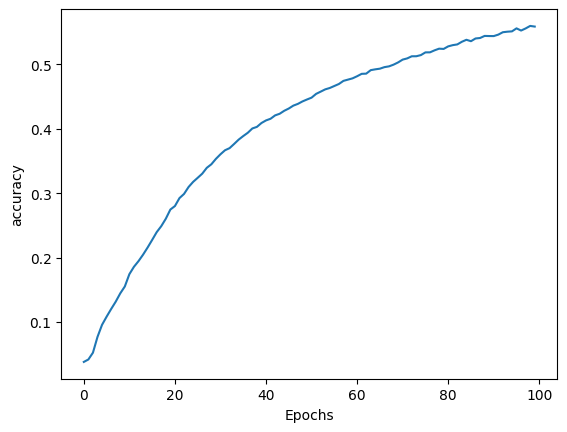

In [49]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(LSTM_history, 'accuracy')

## Generating lyrics

With max probability choice

In [55]:
seed_text = "I close my front door and turn on the light"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(LSTM_model.predict(token_list, verbose=0), axis=-1)

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

I close my front door and turn on the light oh away eyes look new direction chick flow two moonlight fades darling ahead ahead completely eyes will die yo yine dead remember desire space desire remember remember everyone's soul shake behind space tenths day away game world world world world inside yourself yourself number money inside inside you gotta be above it gotta be above it gotta be above it gotta be above it inside come inside inside come back back again oh before you mind are approaching reality in motion back again will fly voice sing away one etmemen sun optimism singers drums moment fear please human woman world


With probabilistic choice

In [52]:
seed_text = "I close my front door and turn on the light"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = LSTM_model.predict(token_list, verbose=0)[0]
    predicted = np.random.choice([x for x in range(len(predicted_probs))],
                                 p=predicted_probs)
    
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

I close my front door and turn on the light and away away away yo lyricstba oh doors eyes look feelin' will know will world şeye nothings drums voice desire love desire go control snakes in dover listen encounters space eyes sing away door my shadow falling livin' need girl care hell seems tried said come life old go need memory memory first inside were back up again long inside you nearly again maybe come inside come other side oh yo geriye force who's turn mind know yo yine olmaz space clues mind choose heart first terrified have first completely meanwhile talkin' memory not front of saved completely shake it
